# Virtual Metering

Actual well production data is recorded after wells go on production. The production was modelled in Prosper, a well flow simulator, which attempted to replicate the metered production values using downhole and wellhead pressures and temperatures along with CGR and WGR, in order to better understand the well physics. Prosper modelling takes a lot of effort to set up and calibrate and it also takes a long time to run when large volumes of data are being simulated. Consequently, the sampling frequency was reduced to once daily (which still took a few hours to simulate 60 days of production. Using a Random Forest model is quite straightforward and the calculation time is extremely rapid. This would allow the sampling frequency to be increased and the model could be further integrated into a larger workflow.

It should be noted, though, that the machine learning model tells us nothing about the actual physical behaviour. Machine learning tools are based on statistical matches using coefficients, whereas a Prosper model is physics-based.

There are, therefore, two approaches that could be taken:
- Train the ML model on metered (actual measured) production
- Train the ML model on simulated production

If we train on metered production, using verified and trusted data points, then the ML model could be run in tandem to the flow meter. If the metered production and the ML production deviate, this could indicate a problem with the meter or a physical change to the system, indicating a need for further investigation.

If we train in simulated production, then the ML model could be run in tandem to the flow meter as a form of virtual metering, which again verifies the quality of the flow meter.

In reality, both methods are so easy to implement that both could be used and cross-checked.

## Load the Production Data

In [1]:
# Load common libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [2]:
# Load ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Load metered data
df_meter = pd.read_csv('meter_test.csv')

In [4]:
# Preprocess data
df_meter = df_meter.drop([0,1])
df_meter = df_meter.set_index('Time')
df_meter.index = pd.to_datetime(df_meter.index)
df_meter = df_meter.astype('float')

In [5]:
# Load simulated data calculated using Prosper
df_sim = pd.read_csv('meter_calc.csv')

In [6]:
# Preprocess data
df_sim = df_sim.drop([0,1])
df_sim['Time'] = pd.to_datetime(df_sim['Time'])
df_sim = df_sim.set_index('Time')
df_sim = df_sim.astype('float')

In [7]:
# Merge the dataframes
df = pd.merge(df_meter, df_sim, left_index=True, right_index=True)

In [8]:
# Clean up column naming
df.rename(columns={'Qgas.i':'Qg_sim', 'Qgas':'Qg_meter'}, inplace=True)

In [9]:
# Define ratios and set to zero if Qgas is zero
df['CGR'] = np.where(df.Qg_meter==0, 0, df.Qcond / df.Qg_meter)
df['WGR'] = np.where(df.Qg_meter==0, 0, df.Qwater / df.Qg_meter)

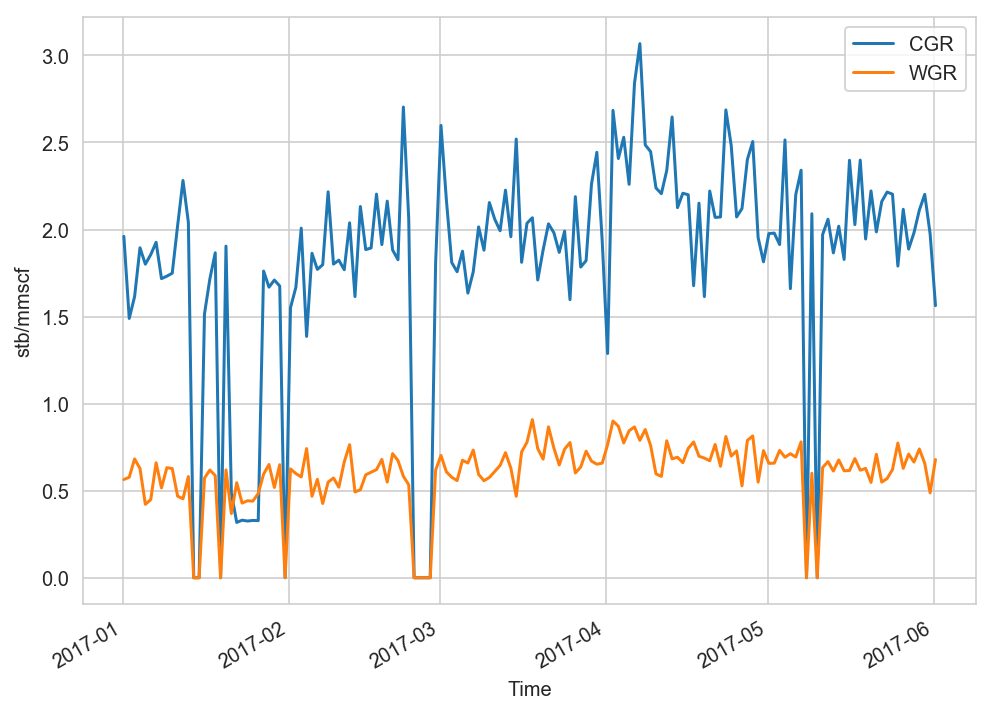

In [10]:
plt.figure(figsize=(8,6))
df.CGR.plot()
df.WGR.plot()
plt.ylabel('stb/mmscf')
plt.legend()
plt.show()

In [11]:
df.head(2)

,PDHG-P,PDHG-T,WHP,WHT,Qg_meter,Qcond,Qwater,Qg_sim,CGR,WGR
Time,,,,,,,,,,
2017-01-01 06:00:00,4788.886719,198.163530,4007.383057,150.251631,70.423714,138.079392,39.740845,70.423714,1.960695,0.564311
2017-01-02 06:00:00,4990.861328,198.704044,4268.623096,142.566482,57.608315,85.787643,33.254822,59.379181,1.489154,0.577257


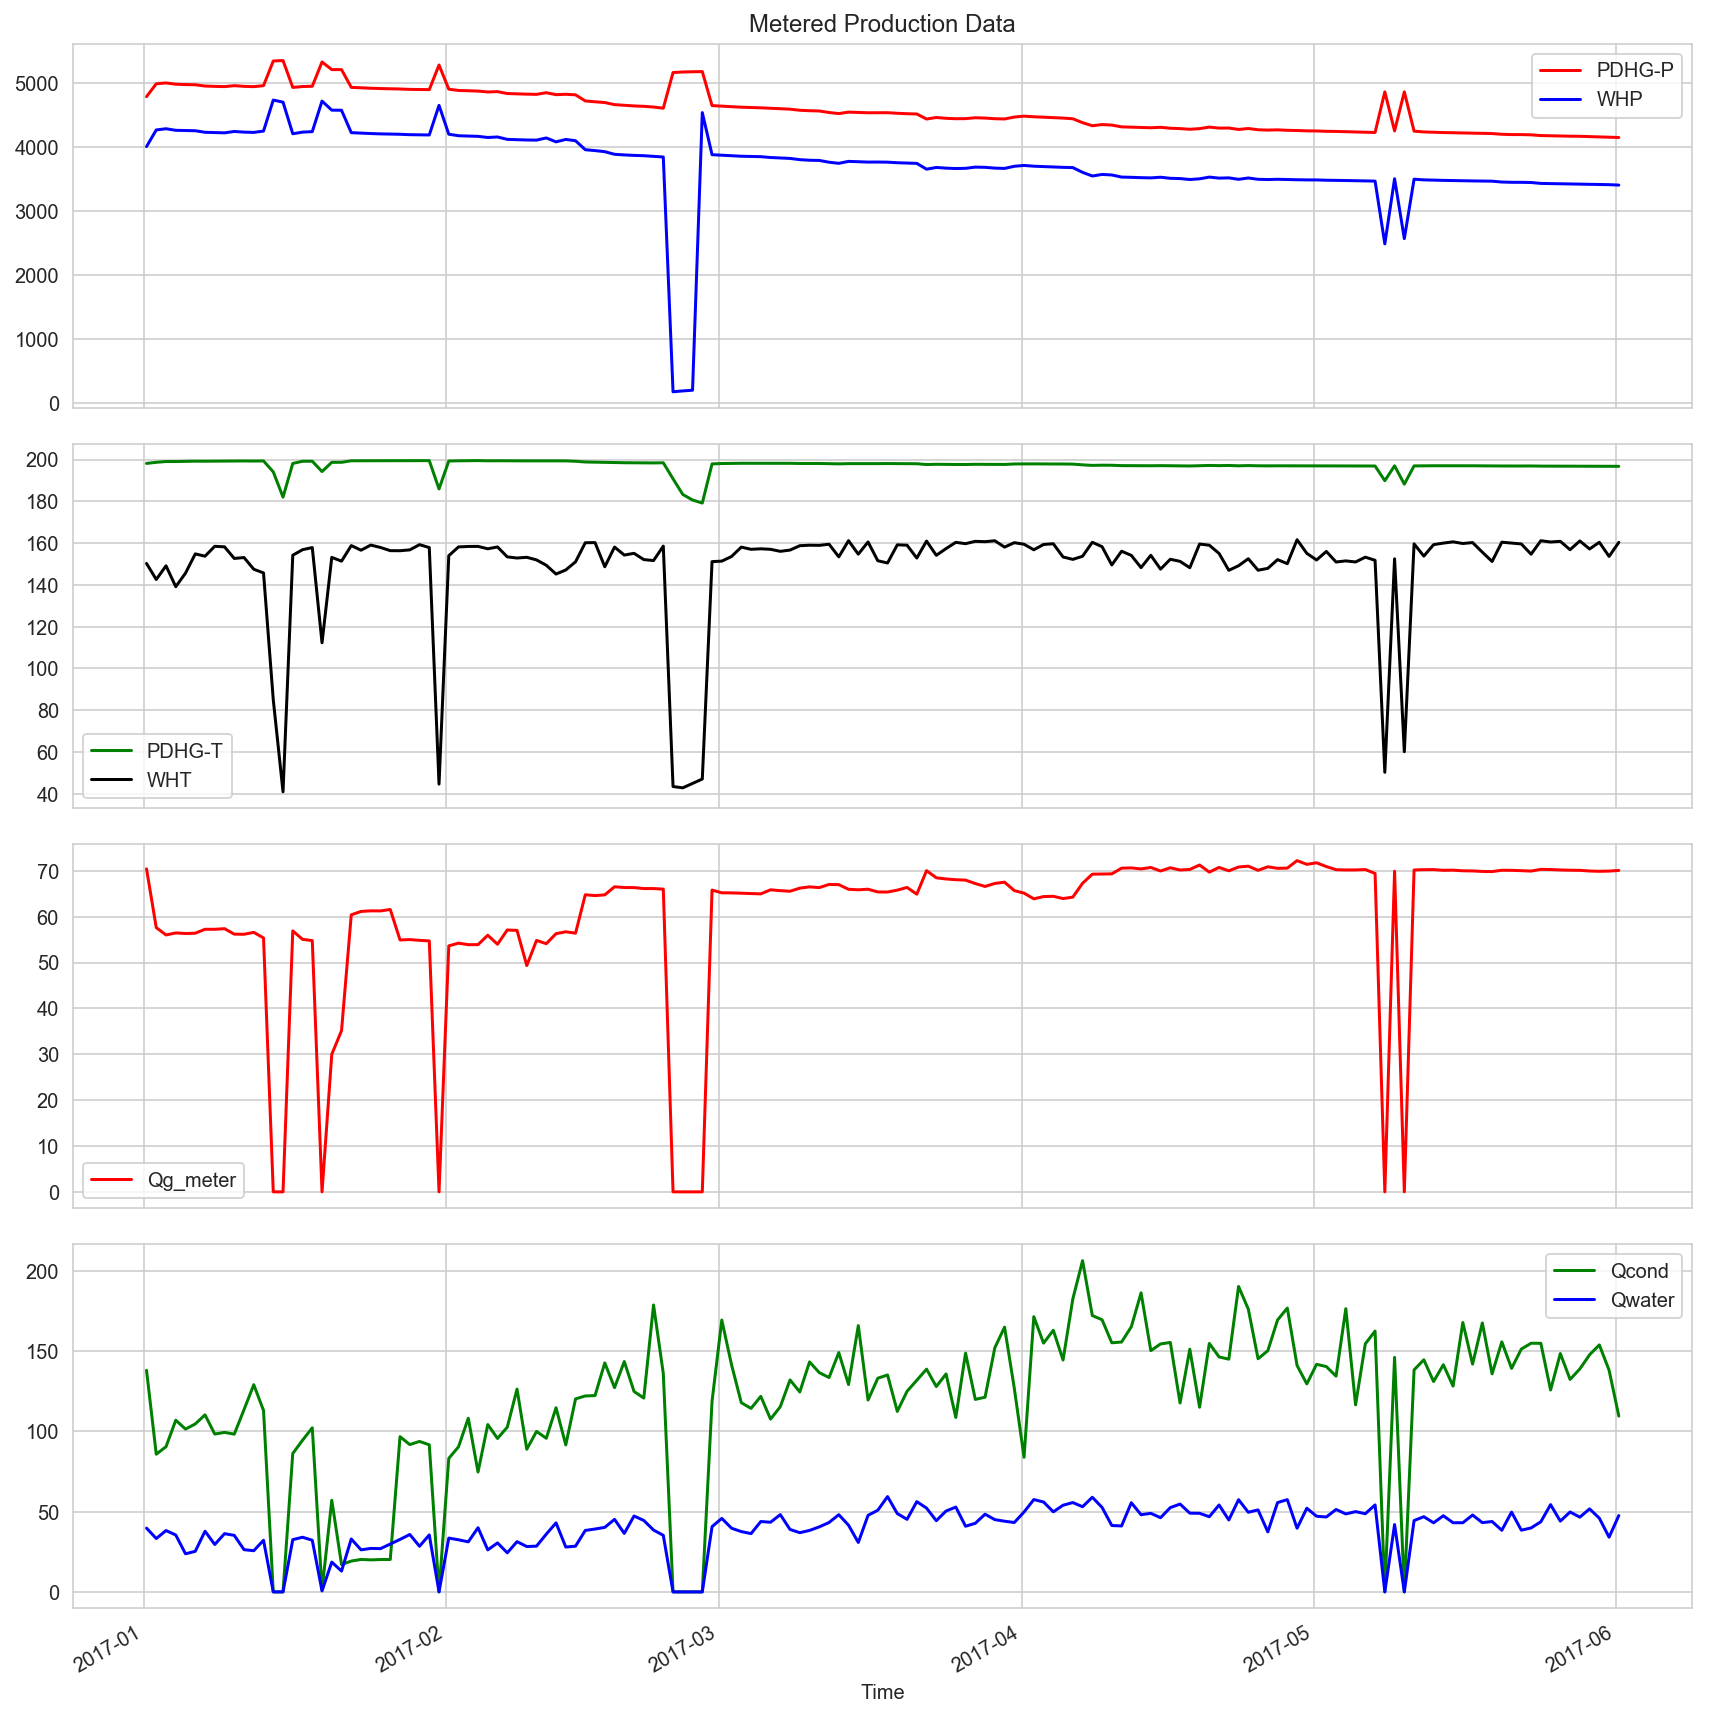

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(12,12), sharex=True)

ax[0].set_title('Metered Production Data')

df['PDHG-P'].plot(ax=ax[0], color='red', legend=True)
df['PDHG-T'].plot(ax=ax[1], color='green', legend=True)
df['WHP'].plot(ax=ax[0], color='blue', legend=True)
df['WHT'].plot(ax=ax[1], color='black', legend=True)
df['Qg_meter'].plot(ax=ax[2], color='red', legend=True)
df['Qcond'].plot(ax=ax[3], color='green', legend=True)
df['Qwater'].plot(ax=ax[3], color='blue', legend=True)

plt.tight_layout()
plt.show()

## Train Model on Metered Production

Since the purpose of using the ML prediction on the data is to check the reliability of the meter, we should assume an unreliable meter to train the model. Therefore, Qcond, Qwater, CGR and WGR should not be used for training and should be dropped. We will use verified Qg_meter data as our label for training and testing.

In [13]:
# Copy data to X
X = df.drop(['Qg_sim', 'Qcond', 'Qwater', 'CGR', 'WGR'], axis=1)

In [14]:
# Generate the target variable.
y = X.pop('Qg_meter')

In [15]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

In [16]:
# Instantiate Standard Scaler
ss = StandardScaler()

In [17]:
# Scale the training set
Xs_train = ss.fit_transform(X_train)

In [18]:
# Instantiate Random Forest Regressor
model = RandomForestRegressor(n_jobs=-1, random_state=7)

In [19]:
model.fit(Xs_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=7, verbose=0, warm_start=False)

In [20]:
kf = KFold(n_splits=5, shuffle=False, random_state=7)

In [21]:
cross_val_score(model, Xs_train, y_train, cv=kf, n_jobs=-1)

array([0.70497436, 0.93375606, 0.89136982, 0.05330231, 0.17002824])

In [22]:
model.score(Xs_train, y_train)

0.9981528389261063

In [23]:
# Scale the test set
Xs_test = ss.transform(X_test)

In [24]:
model.score(Xs_test, y_test)

0.5836033279540651

The training set produces a very good average score, which gives confidence in the model. The test produces only a moderately good score, which indicates that the physical system changes sometime during the test period. Additional data in the future should improve the score.

To view the quality of the results visually, we can rerun the transformation and prediction on the entire data set (using the scaler fit from the train set).

In [25]:
# Scale the entire data set
Xs = ss.transform(X)

In [26]:
# Predict the values for the entire data set to compare against actual data
ypred = model.predict(Xs)
# Ensure production is not negative
ypred = ypred.clip(0)

We can examine the feature importance and also the error trends for signs of non-linearity in the data.

In [27]:
# Set up a dataframe with real and predicted production values
df['Qg_pred_m'] = ypred
df['error_m'] = df['Qg_meter'] - df['Qg_pred_m']
df.head(2)

,PDHG-P,PDHG-T,WHP,WHT,Qg_meter,Qcond,Qwater,Qg_sim,CGR,WGR,Qg_pred_m,error_m
Time,,,,,,,,,,,,
2017-01-01 06:00:00,4788.886719,198.163530,4007.383057,150.251631,70.423714,138.079392,39.740845,70.423714,1.960695,0.564311,67.675758,2.747956
2017-01-02 06:00:00,4990.861328,198.704044,4268.623096,142.566482,57.608315,85.787643,33.254822,59.379181,1.489154,0.577257,57.248745,0.359570


In [28]:
# Set up a dateframe with feature importances
coef_df = pd.DataFrame({'names':X.columns,'coef':model.feature_importances_})

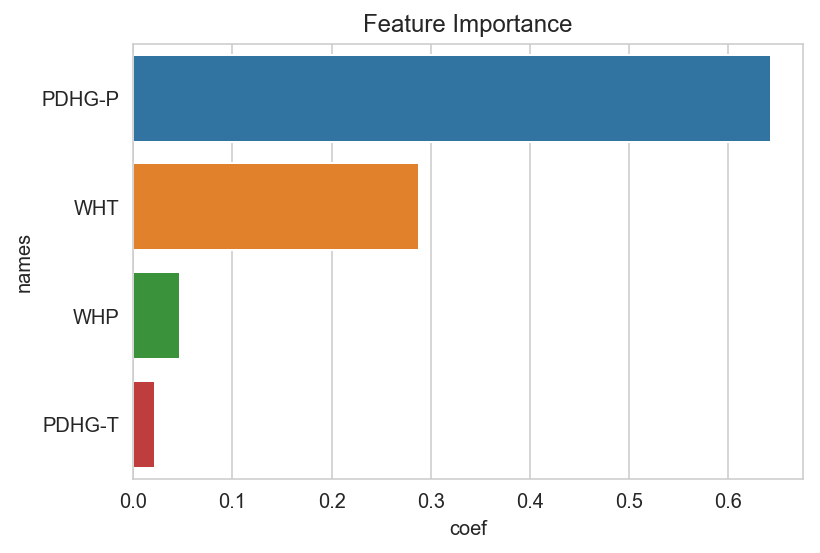

In [29]:
sns.barplot(x='coef', y='names', data=coef_df.sort_values(by='coef',ascending=False))
plt.title('Feature Importance');

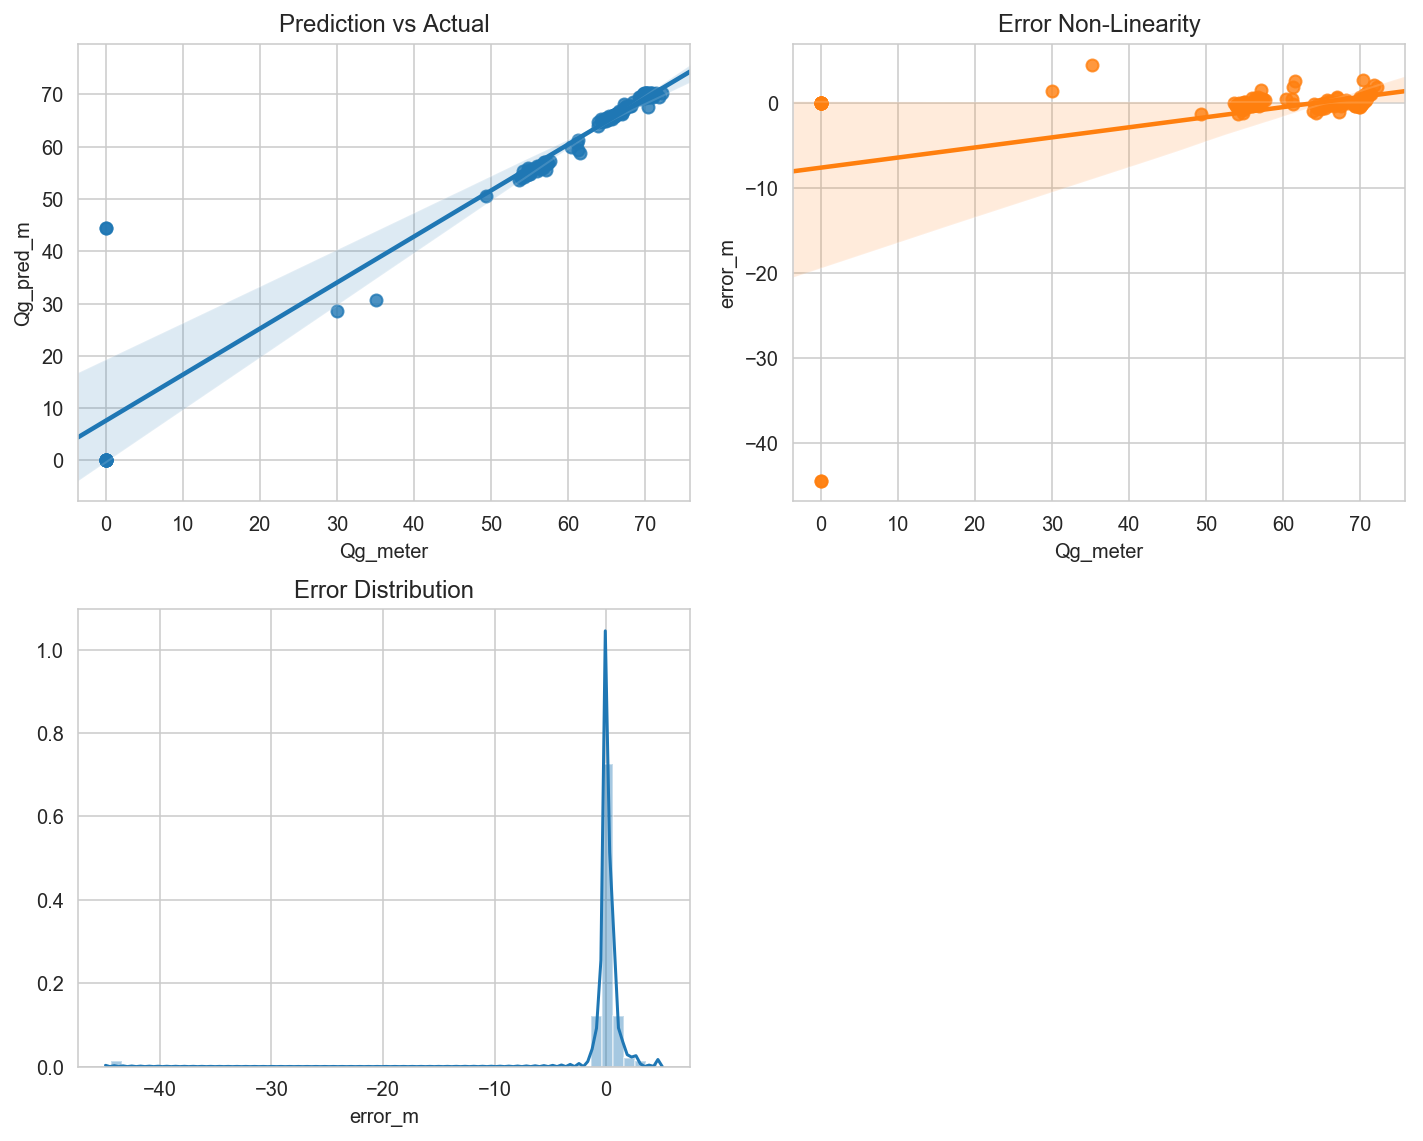

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

sns.regplot(x = 'Qg_meter', y='Qg_pred_m', data=df, ax=ax[0,0])
ax[0,0].set_title('Prediction vs Actual')
sns.regplot(x='Qg_meter', y='error_m', data=df, ax=ax[0,1])
ax[0,1].set_title('Error Non-Linearity')
sns.distplot(df['error_m'], ax=ax[1,0])
ax[1,0].set_title('Error Distribution')
ax[1,1].axis('off')

plt.tight_layout()
plt.show()

Generally, the results are excellent, but there are one or two outliers associated to shut-ins (Qgas = 0) that the regression model cannot match for some reason. This could be improved with additional data in the future.

## Train Model on Simulated Production

Since the purpose of using the ML prediction on the data is to check the reliability of the meter, we should assume an unreliable meter to train the model. Therefore, Qcond, Qwater, CGR and WGR should not be used for training and should be dropped. We will use verified Qg_sim data as our label for training and testing.

In [31]:
# Copy data to X
X = df.drop(['Qg_meter', 'Qcond', 'Qwater', 'CGR', 'WGR', 'Qg_pred_m', 'error_m'], axis=1)

In [32]:
# Generate the target variable.
y = X.pop('Qg_sim')

In [33]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

In [34]:
# Scale the training set
Xs_train = ss.fit_transform(X_train)

In [35]:
model.fit(Xs_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=7, verbose=0, warm_start=False)

In [36]:
kf = KFold(n_splits=5, shuffle=False, random_state=7)

In [37]:
cross_val_score(model, Xs_train, y_train, cv=kf, n_jobs=-1)

array([0.85649529, 0.91889175, 0.76108484, 0.26803307, 0.05963375])

In [38]:
model.score(Xs_train, y_train)

0.9971154615658631

In [39]:
# Scale the test set
Xs_test = ss.transform(X_test)

In [40]:
model.score(Xs_test, y_test)

0.21896768003534917

The training set produces a very good average score, which gives confidence in the model. The test produces a very poor score, which indicates that the physical system changes significantly during the test period. Additional data in the future should improve the score.

To view the quality of the results visually, we can rerun the transformation and prediction on the entire data set (using the scaler fit from the train set).

In [41]:
# Scale the entire data set
Xs = ss.transform(X)

In [42]:
# Predict the values for the entire data set to compare against actual data
ypred = model.predict(Xs)
# Ensure production is not negative
ypred = ypred.clip(0)

We can examine the feature importance and also the error trends for signs of non-linearity in the data.

In [43]:
# Set up a dataframe with real and predicted production values
df['Qg_pred_s'] = ypred
df['error_s'] = df['Qg_sim'] - df['Qg_pred_s']
df.head(2)

,PDHG-P,PDHG-T,WHP,WHT,Qg_meter,Qcond,Qwater,Qg_sim,CGR,WGR,Qg_pred_m,error_m,Qg_pred_s,error_s
Time,,,,,,,,,,,,,,
2017-01-01 06:00:00,4788.886719,198.163530,4007.383057,150.251631,70.423714,138.079392,39.740845,70.423714,1.960695,0.564311,67.675758,2.747956,68.988346,1.435367
2017-01-02 06:00:00,4990.861328,198.704044,4268.623096,142.566482,57.608315,85.787643,33.254822,59.379181,1.489154,0.577257,57.248745,0.359570,58.914421,0.464760


In [44]:
# Set up a dateframe with feature importances
coef_df = pd.DataFrame({'names':X.columns,'coef':model.feature_importances_})

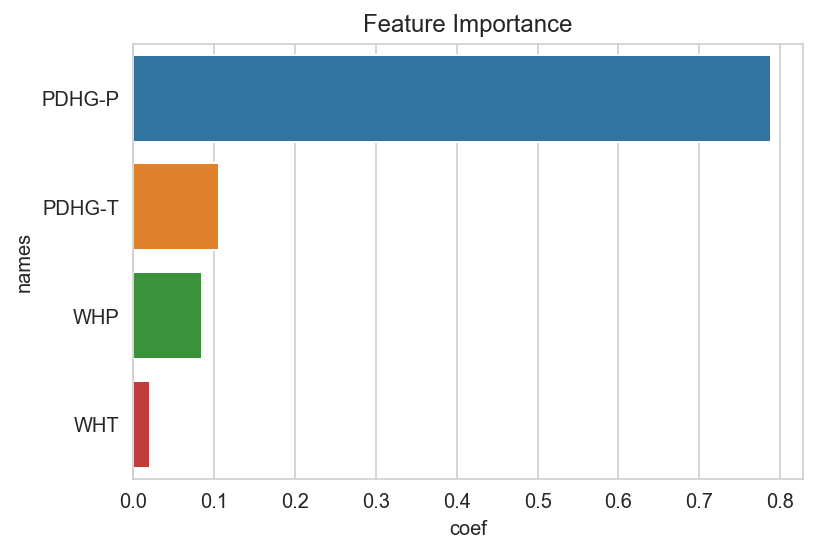

In [45]:
sns.barplot(x='coef', y='names', data=coef_df.sort_values(by='coef',ascending=False))
plt.title('Feature Importance');

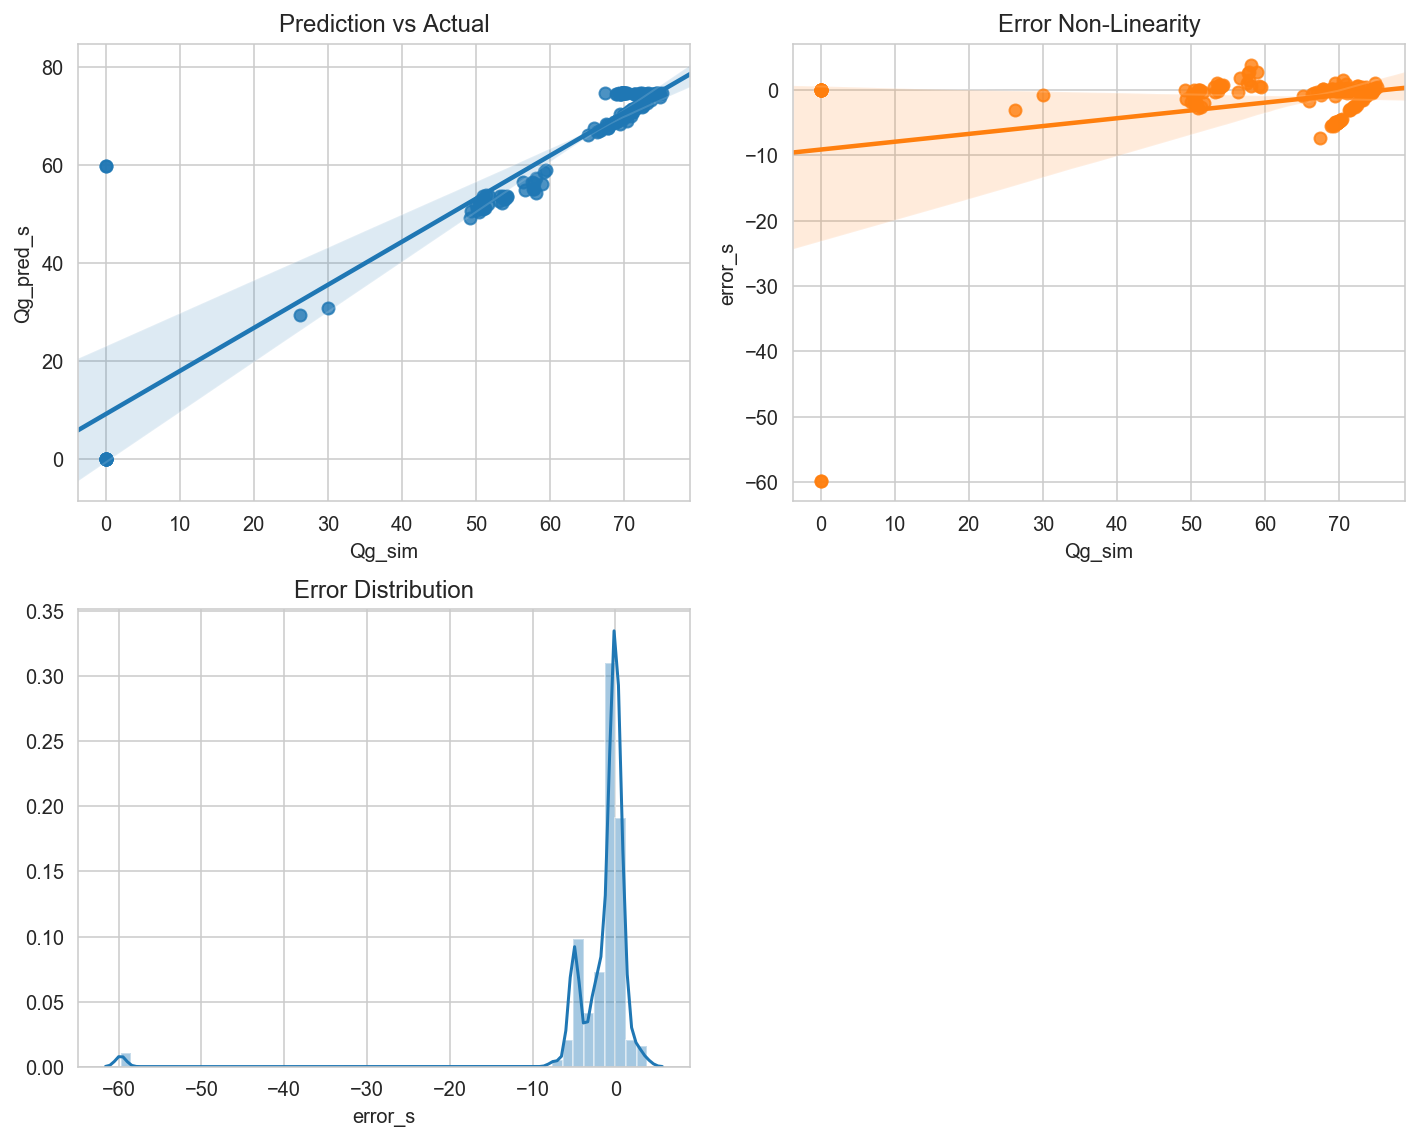

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

sns.regplot(x = 'Qg_sim', y='Qg_pred_s', data=df, ax=ax[0,0])
ax[0,0].set_title('Prediction vs Actual')
sns.regplot(x='Qg_sim', y='error_s', data=df, ax=ax[0,1])
ax[0,1].set_title('Error Non-Linearity')
sns.distplot(df['error_s'], ax=ax[1,0])
ax[1,0].set_title('Error Distribution')
ax[1,1].axis('off')

plt.tight_layout()
plt.show()

Generally, the results are excellent, but there are one or two outliers associated to shut-ins (Qgas = 0) that the regression model cannot match for some reason. This could be improved with additional data in the future.

## Final Results

Plotting the results of the metered production, the simulated production and the two predictions using machine learning, we can visually inspect the quality of the matches and identify problem spots.

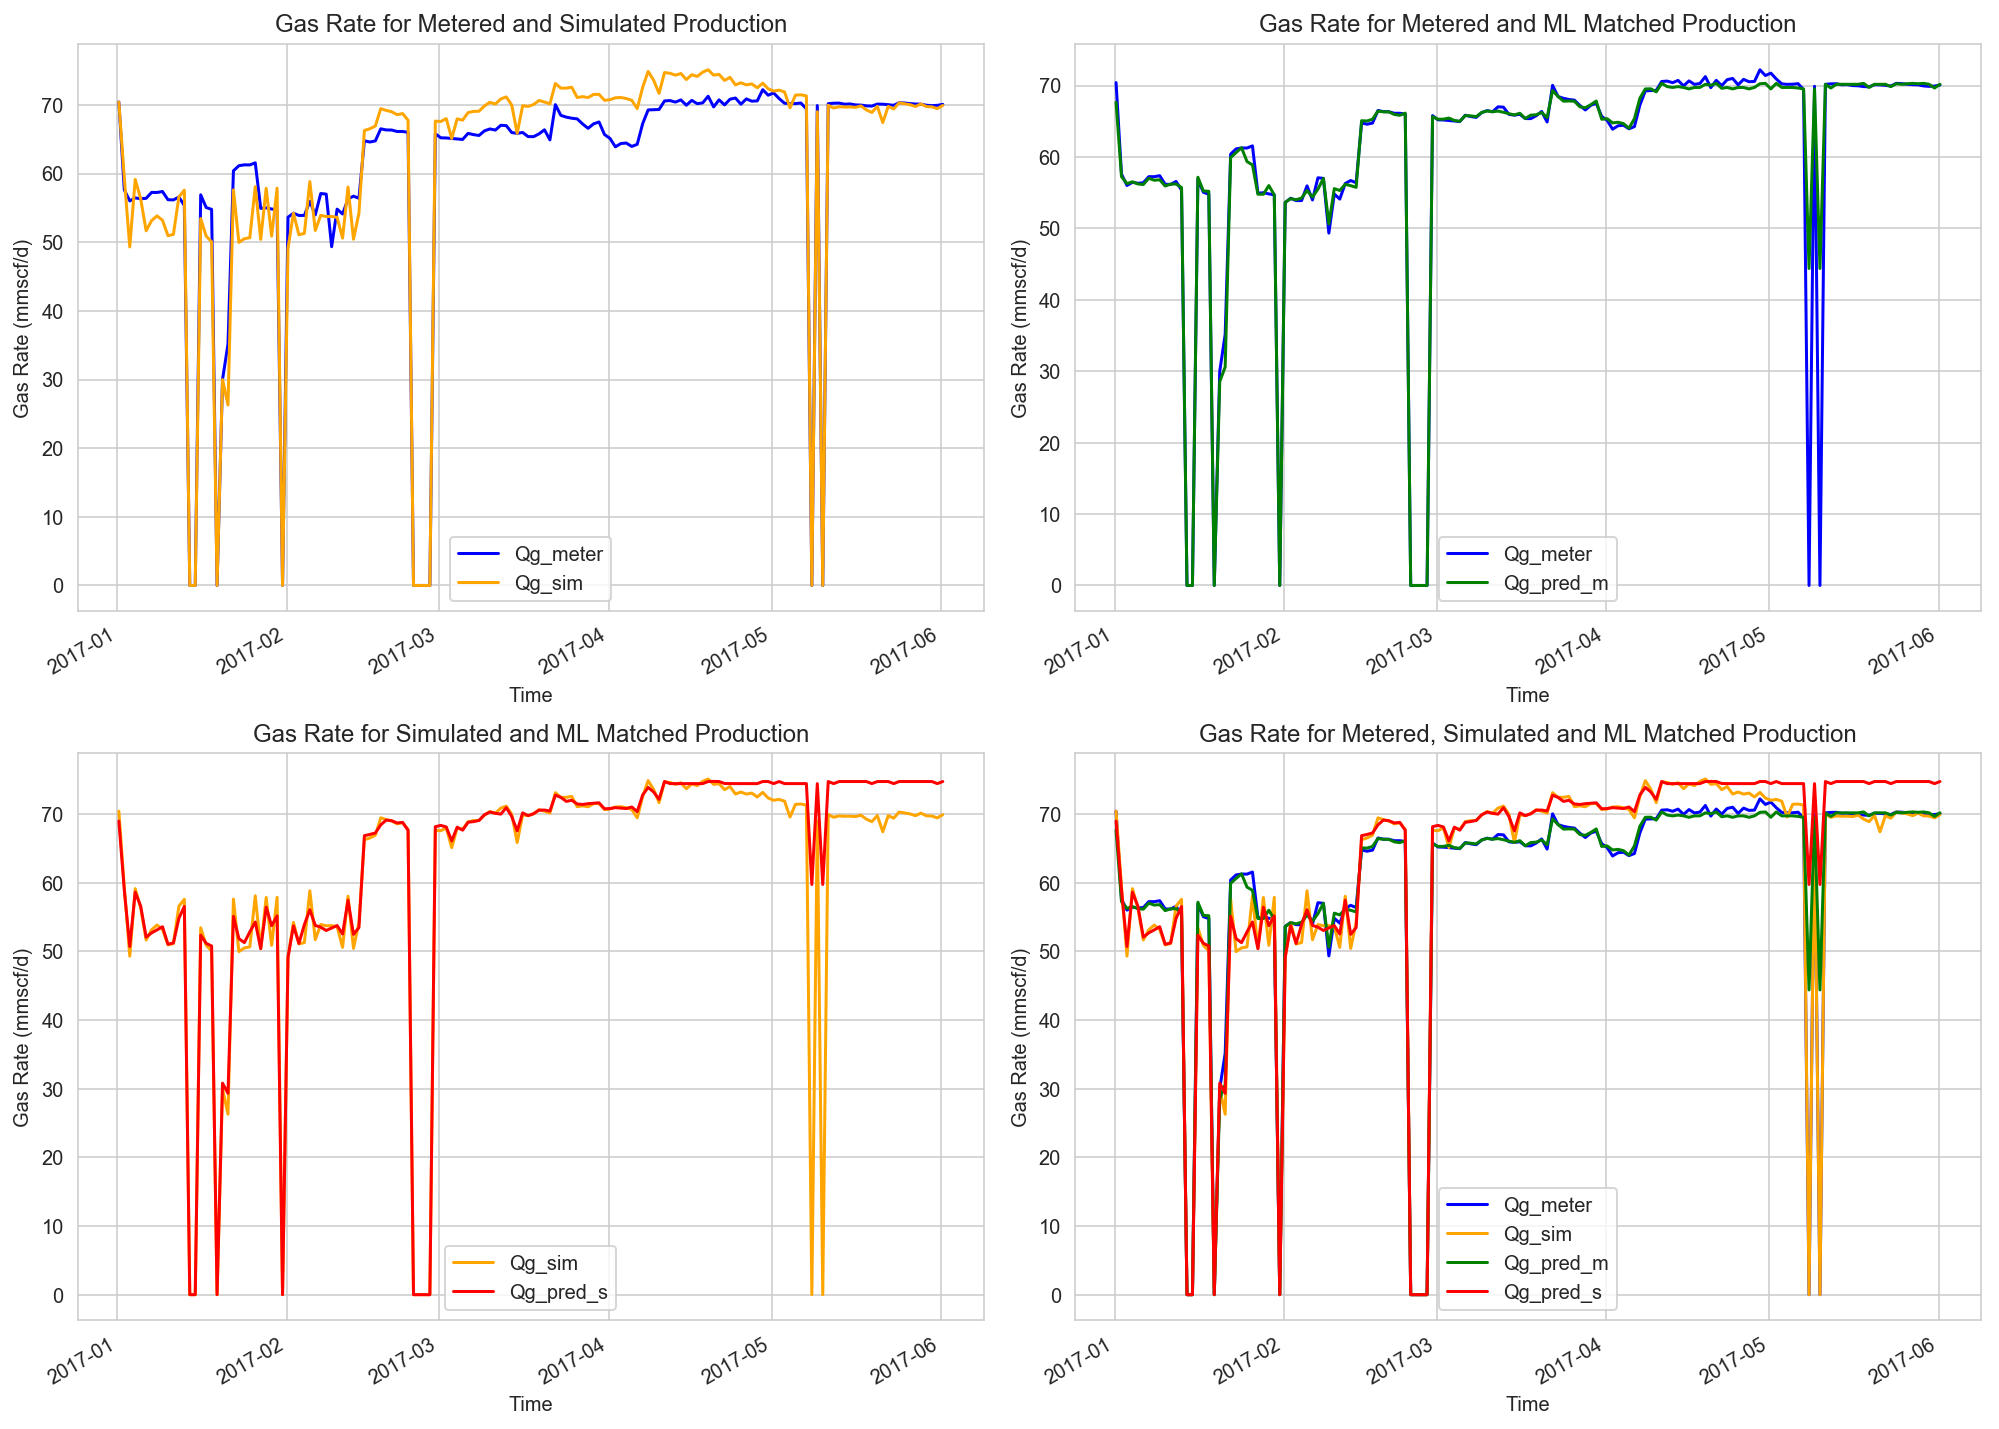

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

df['Qg_meter'].plot(legend=True, ax=ax[0,0], color='blue')
df['Qg_sim'].plot(legend=True, ax=ax[0,0], color='orange')
ax[0,0].set_title('Gas Rate for Metered and Simulated Production')
ax[0,0].set_ylabel('Gas Rate (mmscf/d)')

df['Qg_meter'].plot(legend=True, ax=ax[0,1], color='blue')
df['Qg_pred_m'].plot(legend=True, ax=ax[0,1], color='green')
ax[0,1].set_title('Gas Rate for Metered and ML Matched Production')
ax[0,1].set_ylabel('Gas Rate (mmscf/d)')

df['Qg_sim'].plot(legend=True, ax=ax[1,0], color='orange')
df['Qg_pred_s'].plot(legend=True, ax=ax[1,0], color='red')
ax[1,0].set_title('Gas Rate for Simulated and ML Matched Production')
ax[1,0].set_ylabel('Gas Rate (mmscf/d)')

df['Qg_meter'].plot(legend=True, ax=ax[1,1], color='blue')
df['Qg_sim'].plot(legend=True, ax=ax[1,1], color='orange')
df['Qg_pred_m'].plot(legend=True, ax=ax[1,1], color='green')
df['Qg_pred_s'].plot(legend=True, ax=ax[1,1], color='red')
ax[1,1].set_title('Gas Rate for Metered, Simulated and ML Matched Production')
ax[1,1].set_ylabel('Gas Rate (mmscf/d)')


plt.tight_layout()
plt.show()

The random forest regressor clearly had a difficult time with the two shut-ins in the test set, both when trying to mimic the metered production and also the simulated production. Perhaps with additional gridsearching, this could be improved. It might also indicate a change in the system physics, such as liquid ratios changing or the well continuing to clean up.

In [48]:
score_prosper = r2_score(df['Qg_meter'], df['Qg_sim'])
score_rforest = r2_score(df['Qg_meter'], df['Qg_pred_m'])
score_rfprosper = r2_score(df['Qg_sim'], df['Qg_pred_s'])

In [49]:
print('R2 Score')
print('--------')
print('Prosper Prediction of Metered Qgas: {}'.format(round(score_prosper,3)))
print('Random Forest Prediction of Metered Qgas: {}'.format(round(score_rforest,3)))
print('Random Forest Prediction of Qg_sim(Prosper): {}'.format(round(score_rfprosper,3)))

R2 Score
--------
Prosper Prediction of Metered Qgas: 0.957
Random Forest Prediction of Metered Qgas: 0.912
Random Forest Prediction of Qg_sim(Prosper): 0.847


Overall, however, the matches were very good on the metered gas and reasonably good on the simulated gas.